# Th analysis

In [1]:
%matplotlib inline

import os
import random
import sys
import textwrap

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy  as np
import tables as tb

import invisible_cities.core.core_functions as coref
import invisible_cities.core.fit_functions as fitf
import invisible_cities.reco.dst_functions  as dstf
import invisible_cities.reco.paolina_functions as plf

from   collections                             import namedtuple
from   invisible_cities.io.hits_io             import load_hits
from   invisible_cities.io.hits_io             import load_hits_skipping_NN
from   invisible_cities.evm.event_model        import Hit, Cluster, HitCollection
from   invisible_cities.types.ic_types         import xy
from   invisible_cities.types.ic_types         import NN
from   invisible_cities.core.system_of_units_c import units
from   matplotlib.patches                      import Ellipse
from   mpl_toolkits.mplot3d                    import Axes3D

In [11]:
%matplotlib inline

np.warnings.filterwarnings('ignore')

plt.rcParams["figure.figsize"]          = 8, 6
plt.rcParams["font.size"]               = 15
plt.rcParams["figure.max_open_warning"] = 100

profOpt = "--k"
fitOpt  = "r"

## Read the corrections table
Reads the corrections table from the specified file and creates a function that returns the correction factor for a given (x,y) location.

In [2]:
corr_file = "/home/brais/Documents/Next//Correction_maps/run4628_corrections.h5"
fcorr     = dstf.load_xy_corrections(corr_file)

## Read in the output of Penthesilea
Reads in Penthesilea output from the runs listed

In [3]:
def merge_NN_hits(hits_all,hits_nonNN):

    # Iterate through the nonNN dictionary and update the energies including the NN hits from the "all" dictionary.
    for (evt,hc) in hits_nonNN.items():

        # Get the corresponding collection of all hits.
        hc_all = hits_all[evt]
            
        # Add energy from all NN hits to hits in closest slice.
        for h1 in hc_all.hits:

            if(h1.Q == NN):

                # Find the hits to which the energy will be added.
                zdist_min = -1
                h_add = []
                for h2 in hc.hits:
                    zdist = np.abs(h1.Z - h2.Z)
                    if(zdist_min < 0 or zdist < zdist_min):
                        zdist_min = zdist
                        h_add = []
                        h_add.append(h2)
                    elif(zdist == zdist_min):
                        h_add.append(h2)

                # Add the energy.
                hadd_etot = sum([ha.E for ha in h_add])
                for ha in h_add:
                    ha.energy += h1.E*(ha.E/hadd_etot)
                    
        # Check the sum of the energy.
        #e1 = sum([hh.E for hh in hc_all.hits])
        #e2 = sum([hh.E for hh in hc.hits])
        #if(abs(e1 - e2) > 0.001):
        #    print("ERROR")


In [8]:
tlife  = 1544


In [24]:
fname = "/home/brais/Documents/Next/Na/data/4567_dev/hit_dst_4567.root.h5"
hits_all = load_hits(fname, 50000)
hits = load_hits_skipping_NN(fname, 50000)



size:  50000


In [33]:
# Create the corrected hit collections (summed over all runs) for 
#  fully corrected (c), geometry-only corrected (g), tau-only corrected (t), and uncorrected (u) events.
hitc_uevt = []; hitc_cevt = []; hitc_gevt = []; hitc_tevt = []

for ee,hc in hits.items():
    hc_ucorr = []; hc_corr = []; hc_gcorr = []; hc_tcorr = []
    for hh in hc.hits:

        hecorr = hh.E*fcorr(hh.X,hh.Y).value/np.exp(-hh.Z/1200.)
        hegcorr = hh.E*fcorr(hh.X,hh.Y).value
        hetcorr = hh.E/np.exp(-hh.Z/tlife)

        hucorr = Hit(0,Cluster(0, xy(hh.X,hh.Y), xy(0,0), 0),hh.Z,hh.E)
        hcorr  = Hit(0,Cluster(0, xy(hh.X,hh.Y), xy(0,0), 0),hh.Z,hecorr)
        hgcorr = Hit(0,Cluster(0, xy(hh.X,hh.Y), xy(0,0), 0),hh.Z,hegcorr)
        htcorr = Hit(0,Cluster(0, xy(hh.X,hh.Y), xy(0,0), 0),hh.Z,hetcorr)

        hc_ucorr.append(hucorr); hc_corr.append(hcorr); hc_gcorr.append(hgcorr); hc_tcorr.append(htcorr)

    # Only save events with >= 2 hits.
    if(len(hc_corr) >= 1):
        hitc_uevt.append(hc_ucorr)
        hitc_cevt.append(hc_corr)
        hitc_gevt.append(hc_gcorr)
        hitc_tevt.append(hc_tcorr)

## Control Plots

### # of hits per event

(array([ 506.,  955.,  522.,  212.,   85.,   24.,    9.,    5.,    1.,    2.]),
 array([  3. ,  10.1,  17.2,  24.3,  31.4,  38.5,  45.6,  52.7,  59.8,
         66.9,  74. ]),
 <a list of 10 Patch objects>)

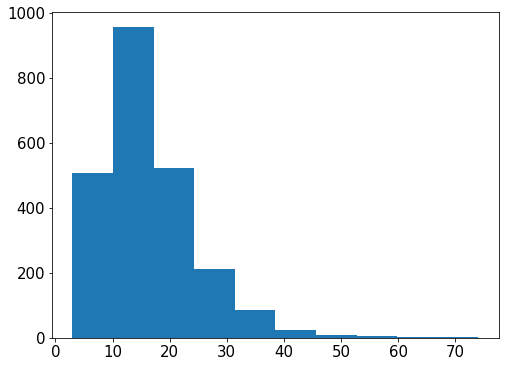

In [34]:
plt.hist(list([len(evt) for evt in hitc_cevt]))

### Hit energy

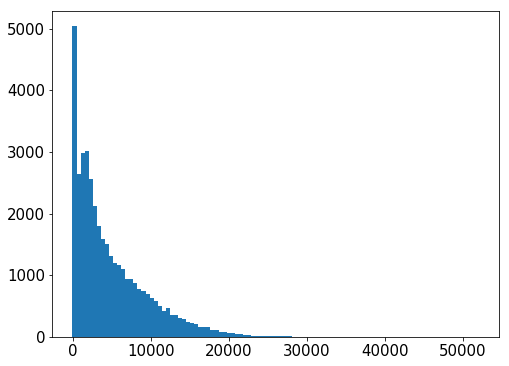

In [79]:
hit_E = []
for evt in hitc_cevt:
    for hit in evt:
        hit_E.append(hit.E[0])
        
plt.hist(hit_E, 100);

### Event Energy

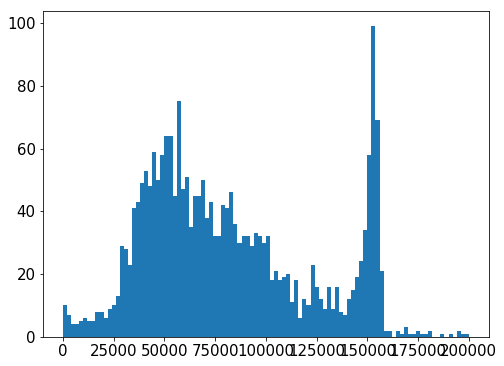

In [81]:
evt_E = []

for evt in hitc_cevt:
    hit_E = []
    for hit in evt:
        hit_E.append(hit.E[0])
    evt_E.append(np.sum(hit_E))
        
plt.hist(evt_E, 100, [0,2e5]);

### XY Hit position 

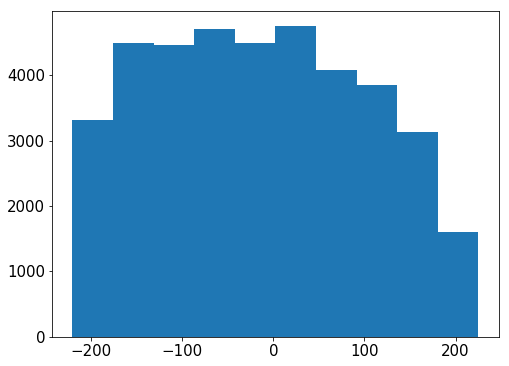

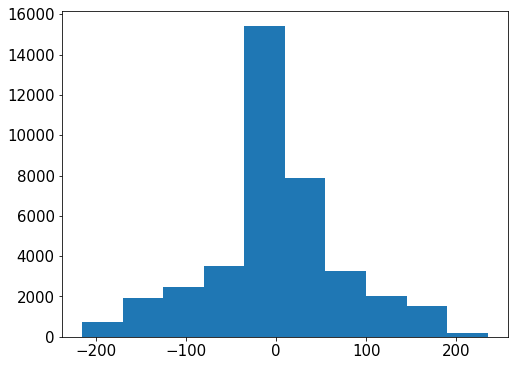

In [88]:
hit_x = []
hit_y = []

for evt in hitc_cevt:
    for hit in evt:
        hit_x.append(hit.XY[0])
        hit_y.append(hit.XY[1])

plt.figure()
plt.hist(hit_x)

plt.figure()
plt.hist(hit_y);


### Average XY position

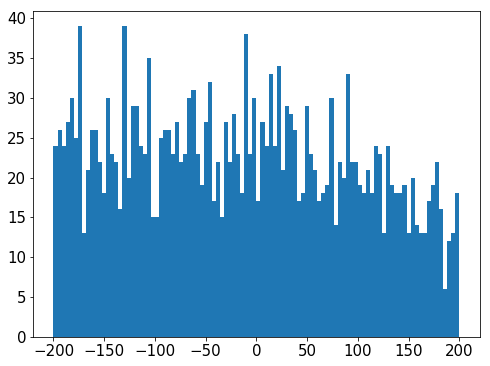

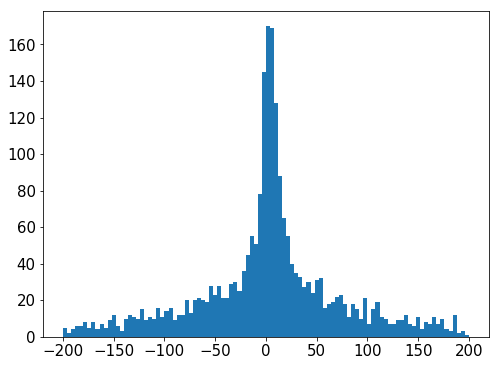

In [115]:
evt_x = []; evt_y = []; 

for ee in range(len(hitc_cevt)):
    
    evt_E = sum([hh.E for hh in hitc_cevt[ee]])[0]
    evt_x.append(sum([hh.X*hh.E for hh in hitc_cevt[ee]])[0]/evt_E)
    evt_y.append(sum([hh.Y*hh.E for hh in hitc_cevt[ee]])[0]/evt_E)

    
plt.figure()
plt.hist(evt_x, 100, [-200,200])

plt.figure()
plt.hist(evt_y, 100, [-200,200]);